# Political Persuasion

## Business Problem

The following case study centers around the idea of political targeting to sway voter opinion using campaign marketing. Similar to identifying a customer's propensity to purchase and targeting them with marketing communication, the general goal it to create a predictive model to understand propensity to "respond" to a political targeting campaign. However, just modeling propensity is not sufficient, as a customer or voter may have already been likely to respond in the absence of marketing. 

The goal here is instead uplift modeling, and target customers who have the highest probability of being swayed given they receive marketing materials after removing a baseline probability to respond without any marketing communications. In mathematical terms, it is ranking customers based on the difference of probability to respond given the treatment minus probability to respond given no treatment. 

In this case, an experiment consisted of the following steps:

1. Conduct a pre-survey of the voters to determine their inclination to vote Democratic
2. Randomly split the into two samples -- control and treatment
3. Send a flyer promoting the Democratic candidate to the treatment group
4. Conduct another survey of the voters to determine their inclination to vote Democratic

**Data**

Data for this case consists of a variables to indicate if a voter's opinion moved in favor of the Democratic candidate as well as if they recevied the treatment flyer. Additional variables come from a variety of sources:

1. Government voter files
2. Political party files
3. Commerical consumer and demogrpahic data
4. Census neighborhood data

**Goal:**

The task in this case is to develop an uplift model that predicts the uplift for each voter. In this fictious example, the campaign has limited resources and wants to optimize their next sendout to the top 10% of voters. The deliverable of this project will be a predictive uplift model and cutoff identified for targeting voters. 

## Data Understanding

While we have a general understanding of the sources of this data, we do not have a data dictionary for the variables. It could be that the client purchased data to append to records but doesn't know the specifics of what they ordered. Or potentially the person that constructed this dataset is no longer with the company. 

Normally, this would lead to additionally collaboration to identify any source information on our variables, but in this case we will have to be careful with the assumptions we make as we analyze and process the dataset for modeling.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "white")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
voters = pd.read_csv('data/raw/Voter-Persuasion_0.csv')

In [3]:
voters.shape

(10000, 79)

In [4]:
voters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 79 columns):
VOTER_ID         10000 non-null int64
SET_NO           10000 non-null int64
OPP_SEX          10000 non-null int64
AGE              10000 non-null int64
HH_ND            10000 non-null int64
HH_NR            10000 non-null int64
HH_NI            10000 non-null int64
MED_AGE          10000 non-null int64
NH_WHITE         10000 non-null int64
NH_AA            10000 non-null int64
NH_ASIAN         10000 non-null int64
NH_MULT          10000 non-null int64
HISP             10000 non-null int64
COMM_LT10        10000 non-null int64
COMM_609P        10000 non-null int64
MED_HH_INC       10000 non-null int64
COMM_CAR         10000 non-null int64
COMM_CP          10000 non-null int64
COMM_PT          10000 non-null int64
COMM_WALK        10000 non-null int64
KIDS             10000 non-null int64
M_MAR            10000 non-null int64
F_MAR            10000 non-null int64
ED_4COL          1

In [5]:
voters.head()

,VOTER_ID,SET_NO,OPP_SEX,AGE,HH_ND,HH_NR,HH_NI,MED_AGE,NH_WHITE,NH_AA,...,CAND2S,MESSAGE_A,MESSAGE_A_REV,I3,CAND1_UND,CAND2_UND,MOVED_AD,MOVED_A,opposite,Partition
0,193801,2,0,28,1,1,1,37,61,34,...,S,1,0,N,N,N,N,0,1,V
1,627701,1,0,53,2,0,0,46,87,8,...,S,1,0,N,N,N,N,0,1,T
2,306924,2,0,68,2,1,0,41,23,64,...,L,1,0,N,N,N,Y,1,0,T
3,547609,1,0,66,0,2,0,35,53,29,...,S,1,0,N,N,N,N,0,1,T
4,141105,3,0,23,0,3,1,42,74,18,...,S,1,0,N,N,N,N,0,1,T


In [6]:
voters.tail()

,VOTER_ID,SET_NO,OPP_SEX,AGE,HH_ND,HH_NR,HH_NI,MED_AGE,NH_WHITE,NH_AA,...,CAND2S,MESSAGE_A,MESSAGE_A_REV,I3,CAND1_UND,CAND2_UND,MOVED_AD,MOVED_A,opposite,Partition
9995,359896,2,0,46,1,0,1,34,63,29,...,L,0,1,N,N,N,N,0,1,V
9996,456503,3,0,87,0,0,1,45,87,9,...,U,0,1,Y,N,Y,Y,1,0,T
9997,610953,1,0,18,3,0,0,38,76,17,...,S,0,1,N,N,N,N,0,1,T
9998,367417,1,0,50,1,2,0,38,85,4,...,S,0,1,N,N,N,N,0,1,V
9999,492783,1,0,42,1,0,0,40,42,45,...,S,0,1,N,N,N,Y,1,0,V


In [40]:
model_cols = [
    'AGE', 'GENDER_F', 'HH_ND', 'HH_NR', 'HH_NI', 'MED_AGE', 
    'NH_WHITE', 'NH_AA', 'NH_ASIAN', 'NH_MULT', 'REG_DAYS', 'MED_HH_INC',
    'PARTY_D', 'PARTY_I', 'PARTY_R',
    'MESSAGE_A', 'MOVED_AD'
]

voters_df = voters[model_cols]

In [41]:
voters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
AGE           10000 non-null int64
GENDER_F      10000 non-null int64
HH_ND         10000 non-null int64
HH_NR         10000 non-null int64
HH_NI         10000 non-null int64
MED_AGE       10000 non-null int64
NH_WHITE      10000 non-null int64
NH_AA         10000 non-null int64
NH_ASIAN      10000 non-null int64
NH_MULT       10000 non-null int64
REG_DAYS      10000 non-null int64
MED_HH_INC    10000 non-null int64
PARTY_D       10000 non-null int64
PARTY_I       10000 non-null int64
PARTY_R       10000 non-null int64
MESSAGE_A     10000 non-null int64
MOVED_AD      10000 non-null object
dtypes: int64(16), object(1)
memory usage: 1.3+ MB


In [42]:
voters_df['MOVED_AD'].value_counts()

N    6266
Y    3734
Name: MOVED_AD, dtype: int64

In [43]:
voters_df['MOVED_AD'] = voters_df['MOVED_AD'].replace({'Y': 1, 'N': 0})

In [44]:
voters_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,10000.0,50.8697,18.151514,18.0,36.00,51.0,64.0,100.0
GENDER_F,10000.0,0.5704,0.495044,0.0,0.00,1.0,1.0,1.0
HH_ND,10000.0,1.2118,1.310005,0.0,0.00,1.0,2.0,9.0
HH_NR,10000.0,0.7287,1.062172,0.0,0.00,0.0,1.0,9.0
HH_NI,10000.0,0.6120,0.927331,0.0,0.00,0.0,1.0,9.0
MED_AGE,10000.0,39.1617,6.897558,25.0,34.00,38.0,44.0,65.0
NH_WHITE,10000.0,66.3690,19.680711,23.0,58.00,65.0,85.0,99.0
NH_AA,10000.0,21.6791,17.922613,0.0,5.00,17.0,30.0,64.0
NH_ASIAN,10000.0,3.5746,3.651434,0.0,1.00,4.0,4.0,16.0
NH_MULT,10000.0,1.9368,2.092760,0.0,1.00,2.0,2.0,8.0


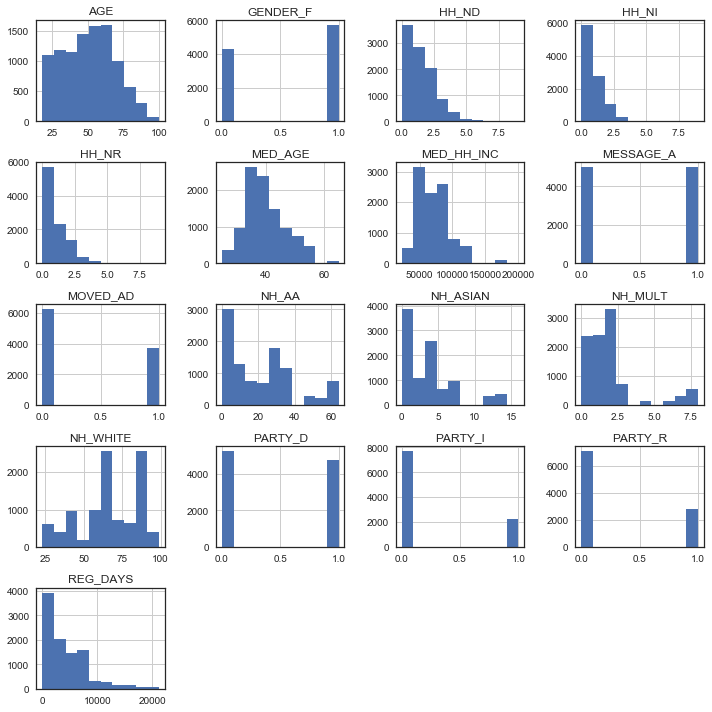

In [45]:
voters_df.hist(figsize=(10,10))
plt.tight_layout();

In [50]:
# split into train and test sets
from sklearn.model_selection import train_test_split

target = ['MOVED_AD']
features = [x for x in voters_df.columns if x not in target]

X_train, X_test, y_train, y_test = train_test_split(
    voters_df[features], voters_df[target], test_size=0.2, random_state=42
)

print(f"Features: \n{features}")
print()
print(f"Targets: \n{target}")
print()
print(f"Training Set: {X_train.shape[0]} rows and {X_train.shape[1]} features")
print(f"Testing Set: {X_test.shape[0]} rows and {X_test.shape[1]} features")

Features: 
['AGE', 'GENDER_F', 'HH_ND', 'HH_NR', 'HH_NI', 'MED_AGE', 'NH_WHITE', 'NH_AA', 'NH_ASIAN', 'NH_MULT', 'REG_DAYS', 'MED_HH_INC', 'PARTY_D', 'PARTY_I', 'PARTY_R', 'MESSAGE_A']

Targets: 
['MOVED_AD']

Training Set: 8000 rows and 16 features
Testing Set: 2000 rows and 16 features


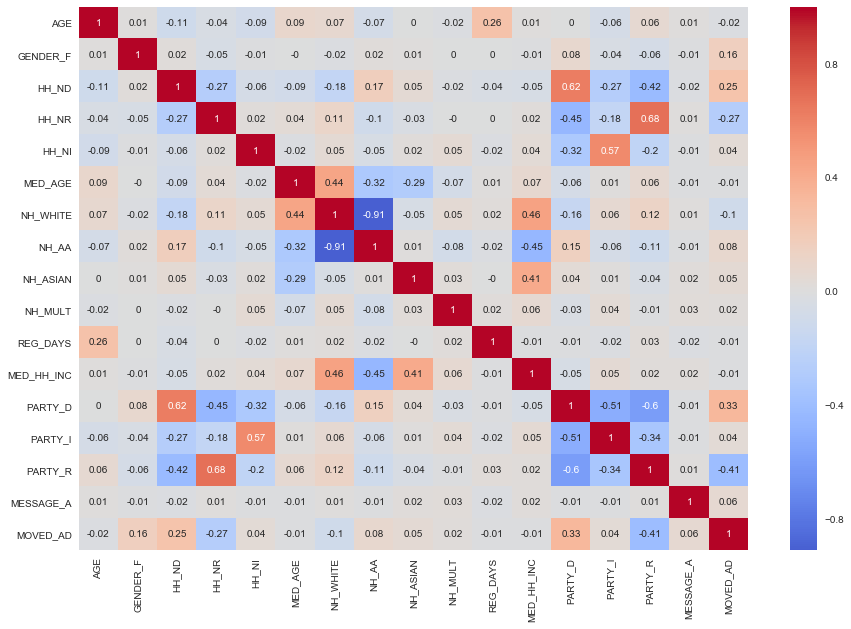

In [51]:
# combine train X,y sets for correlation
corr = pd.concat([X_train, y_train], axis=1).corr()

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr.round(2), 
            center=0,
            cmap='coolwarm',
            annot=True);

## Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV